In [1]:
from statsbombpy import sb
import pandas as pd
import seaborn as sns
import numpy as np
from highlight_text import fig_text
from mplsoccer.pitch import Pitch,VerticalPitch
import matplotlib.pyplot as plt

In [2]:
Euro_matches_id = sb.matches(competition_id= 53 , season_id= 106)["match_id"]
shots_euro = pd.DataFrame()
for id in Euro_matches_id:
    events_match = sb.events(match_id= id)
    df = events_match[events_match["type"] == "Shot"]
    shots_euro = pd.concat([shots_euro, df], axis=0)
shots_euro = shots_euro[
        ['player','location','player_id', 'position','shot_aerial_won',
       'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_freeze_frame', 'shot_key_pass_id', 'shot_one_on_one',
       'shot_outcome', 'shot_saved_off_target', 'shot_saved_to_post',
       'shot_statsbomb_xg', 'shot_technique', 'shot_type','team',
       'timestamp']].reset_index()

In [3]:
def get_x(location):
    return location[0]
def get_y(location):
    return location[1]

shots_euro['x'] = shots_euro['location'].apply(get_x)
shots_euro['y'] = shots_euro['location'].apply(get_y)


## Goals Heatmap

In [4]:
goals = shots_euro[shots_euro['shot_outcome'] == 'Goal'].reset_index()


/Users/aymenkallala/opt/miniconda3/envs/statsbomb/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


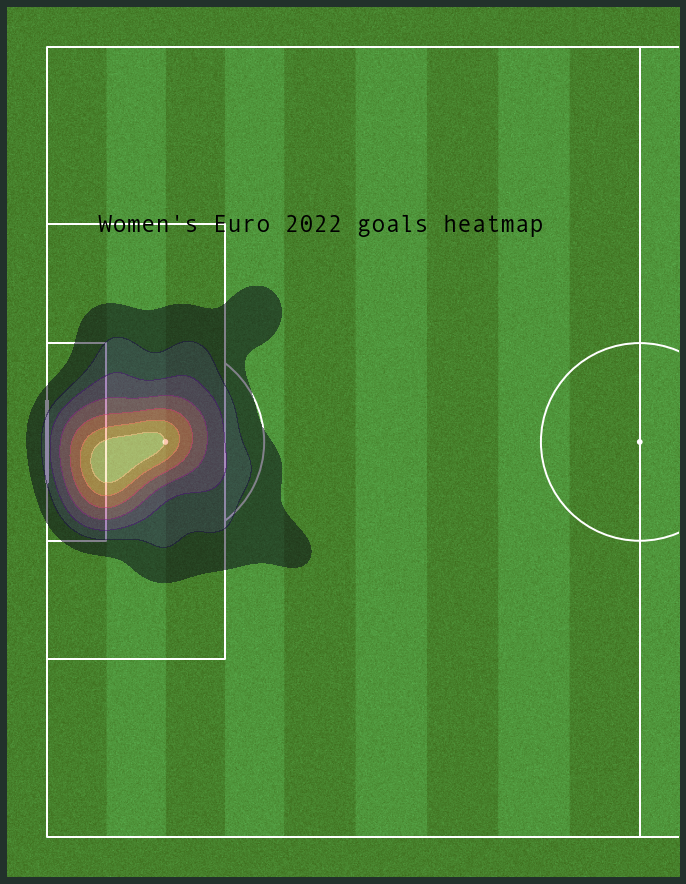

In [5]:
fig, ax = plt.subplots(figsize=(16,16))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')
#Creating the Pitch

pitch = Pitch(pitch_type='statsbomb',pitch_color='grass', line_color='white', stripe=True,half=True)
pitch.draw(ax = ax)
plt.gca().invert_xaxis()

#Plot a title

s="Women's Euro 2022 goals heatmap"
fig_text(s=s,
        x=.30,y=0.7,
        fontfamily='Andale Mono',
        fontsize=24,
        color='black'

)

#Creating the heatmap

kde = sns.kdeplot(
    goals['x'],
    goals['y'],
    shade = True,
    shade_lowest=False,
    alpha=.5,
    n_levels=8,
    cmap = 'magma'

)


plt.savefig("heatmap.jpg")


## Best Scorers shots map

In [6]:
best_scorers = np.array(goals.groupby(by='player').count().sort_values(by='index',ascending=False).index[:5])


In [7]:
best_scorers_shots = pd.DataFrame()

for player in best_scorers:
    best_scorers_shots = pd.concat([shots_euro[shots_euro['player'] == player], best_scorers_shots], axis=0)


best_scorers_goals = pd.DataFrame()

for player in best_scorers:
    best_scorers_goals = pd.concat([goals[goals['player'] == player], best_scorers_goals], axis=0)

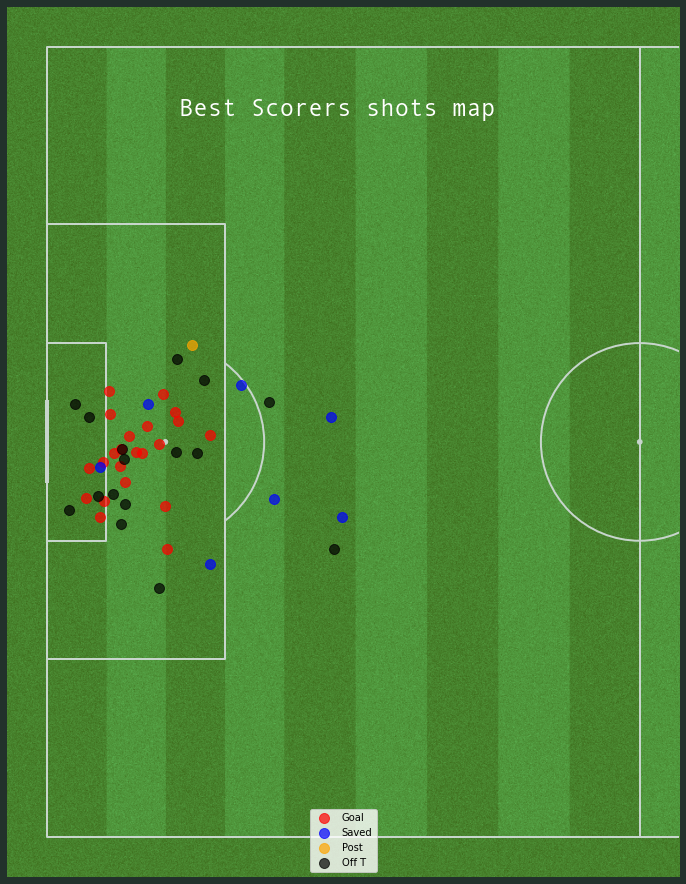

In [8]:
fig, ax = plt.subplots(figsize=(16,16))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

#The statsbomb pitch from mplsoccer
pitch =Pitch(pitch_type='statsbomb', pitch_color='grass',stripe = True, line_color='#c7d5cc',half = True)
pitch.draw(ax = ax)

plt.gca().invert_xaxis()
dict = { 'Goal' : 'red', 'Saved' : 'blue' , 'Post' : 'orange','Off T' : 'black'}

for outcome in dict.keys():
        outcome_shots = best_scorers_shots[best_scorers_shots['shot_outcome'] == outcome]
        plt.scatter(outcome_shots['x'],outcome_shots['y'], s=100,c = dict.get(outcome), alpha = 0.7,label= outcome)
       

ax.legend(loc='best')

s="Best Scorers shots map"
fig_text(s=s,
        x=.37,y=0.8,
        fontfamily='Andale Mono',
        fontsize=24,
        color='white')


plt.savefig("shotsmap.jpg")


## Keira Wlash passes visualization throughout Final

In [9]:
final_events = sb.events(match_id= 3847567)

Walsh_passes = final_events[(final_events['player'] == 'Keira Walsh') & (final_events['type'] == 'Pass')].reset_index()

In [10]:
Walsh_passes['x'] = Walsh_passes['location'].apply(get_x)
Walsh_passes['y'] = Walsh_passes['location'].apply(get_y)
Walsh_passes['endX'] = Walsh_passes['pass_end_location'].apply(get_x)
Walsh_passes['endY'] = Walsh_passes['pass_end_location'].apply(get_y)

In [15]:
def pass_incomplete(x):
    if x in ['Incomplete', 'Pass Offside', 'Unknown'] :
        return True
    else:
        return False

Walsh_passes['pass_incomplete'] = Walsh_passes['pass_outcome'].apply(pass_incomplete)

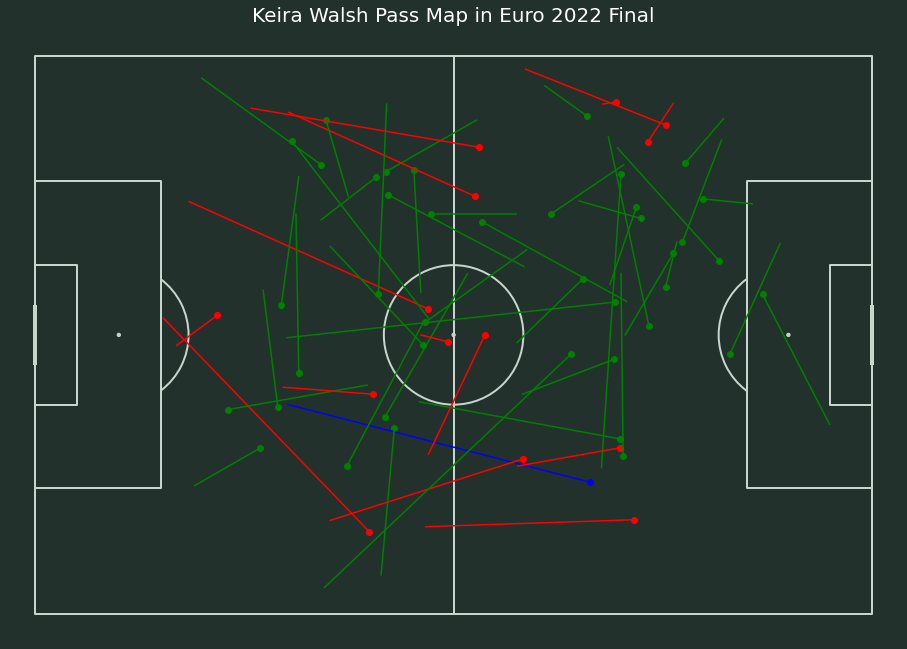

In [16]:
from cProfile import label


fig, ax = plt.subplots(figsize=(16,16))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

#The statsbomb pitch from mplsoccer
pitch =Pitch(pitch_type='statsbomb', pitch_color='#22312b',stripe = False, line_color='#c7d5cc',half = False)
pitch.draw(ax = ax)

plt.gca().invert_xaxis()

for x in range(len(Walsh_passes['x'])):
    if Walsh_passes['pass_goal_assist'][x] == True :
        plt.plot((Walsh_passes['x'][x],Walsh_passes['endX'][x]),(Walsh_passes['y'][x],Walsh_passes['endY'][x]),color='blue',label = 'Assist')
        plt.scatter(Walsh_passes['x'][x],Walsh_passes['y'][x],color='blue')
    elif Walsh_passes['pass_incomplete'][x] == True :
       plt.plot((Walsh_passes['x'][x],Walsh_passes['endX'][x]),(Walsh_passes['y'][x],Walsh_passes['endY'][x]),color='red',label = 'Incomplete Pass')
       plt.scatter(Walsh_passes['x'][x],Walsh_passes['y'][x],color='red')
    elif Walsh_passes['pass_incomplete'][x] == False :
        plt.plot((Walsh_passes['x'][x],Walsh_passes['endX'][x]),(Walsh_passes['y'][x],Walsh_passes['endY'][x]),color='green',label = 'Complete Pass')
        plt.scatter(Walsh_passes['x'][x],Walsh_passes['y'][x],color='green')

plt.title('Keira Walsh Pass Map in Euro 2022 Final',color='white',size=20)


plt.savefig("Walsh_passmap.jpg")